# Demo of KG Graph Data Science for reliability applications

This notebook requires that:
* Neo4j desktop is installed in your machine
* Install Neo4j Graph Data Science library: https://neo4j.com/docs/graph-data-science/2.17/installation/ 
* A neo4j project is initialized with the corresponding Graph DBMS such that the bolt port is available
* the csv files are located in the corresponding folder; on MAC this can be found in this location:
  /"User"/Library/Application Support/Neo4j Desktop/Application/relate-data/dbmss/"dbms-ID"/import

## Steps to communicate with Neo4j 

1. Set import folder path for neo4j, this folder is used to store csv files (default is import folder)

2. Start neo4j desktop DBMS, set password if needed, this password will be used in Python driver to connect to DBMS database 
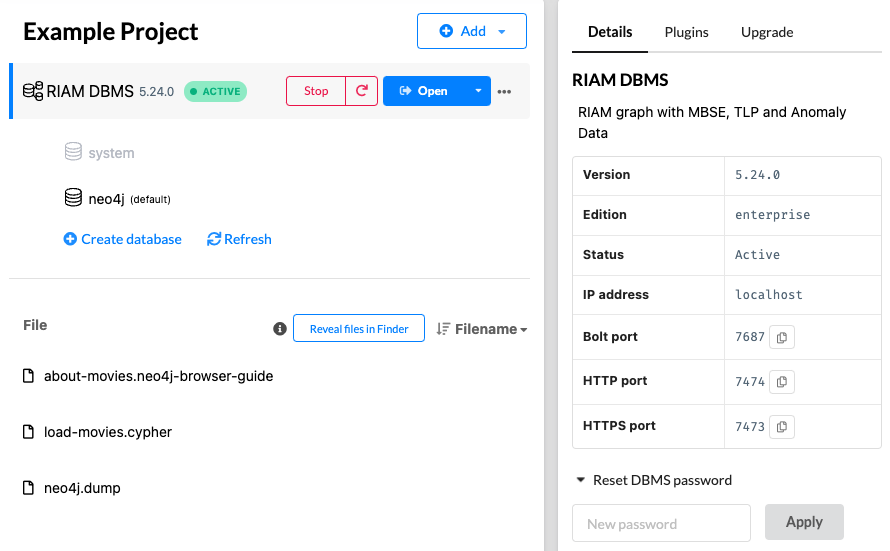
3. Once connection is established, python functions can be used to communicate with Neo4j

## The typical workflow with GDS algorithms is as follows:

- Project an in-memory graph from Neo4j database using gds.graph.project 
- Choose an appropriate algorithm 
- Run the algorithm in one of the execution modes 

  - Use the stream mode to retrieve the output of the algorithm as a query result.
  - Use the mutate mode to update the in-memory graph with the output of the algorithm 
  - Use the write mode to write the output of the algorithm back to the Neo4j database


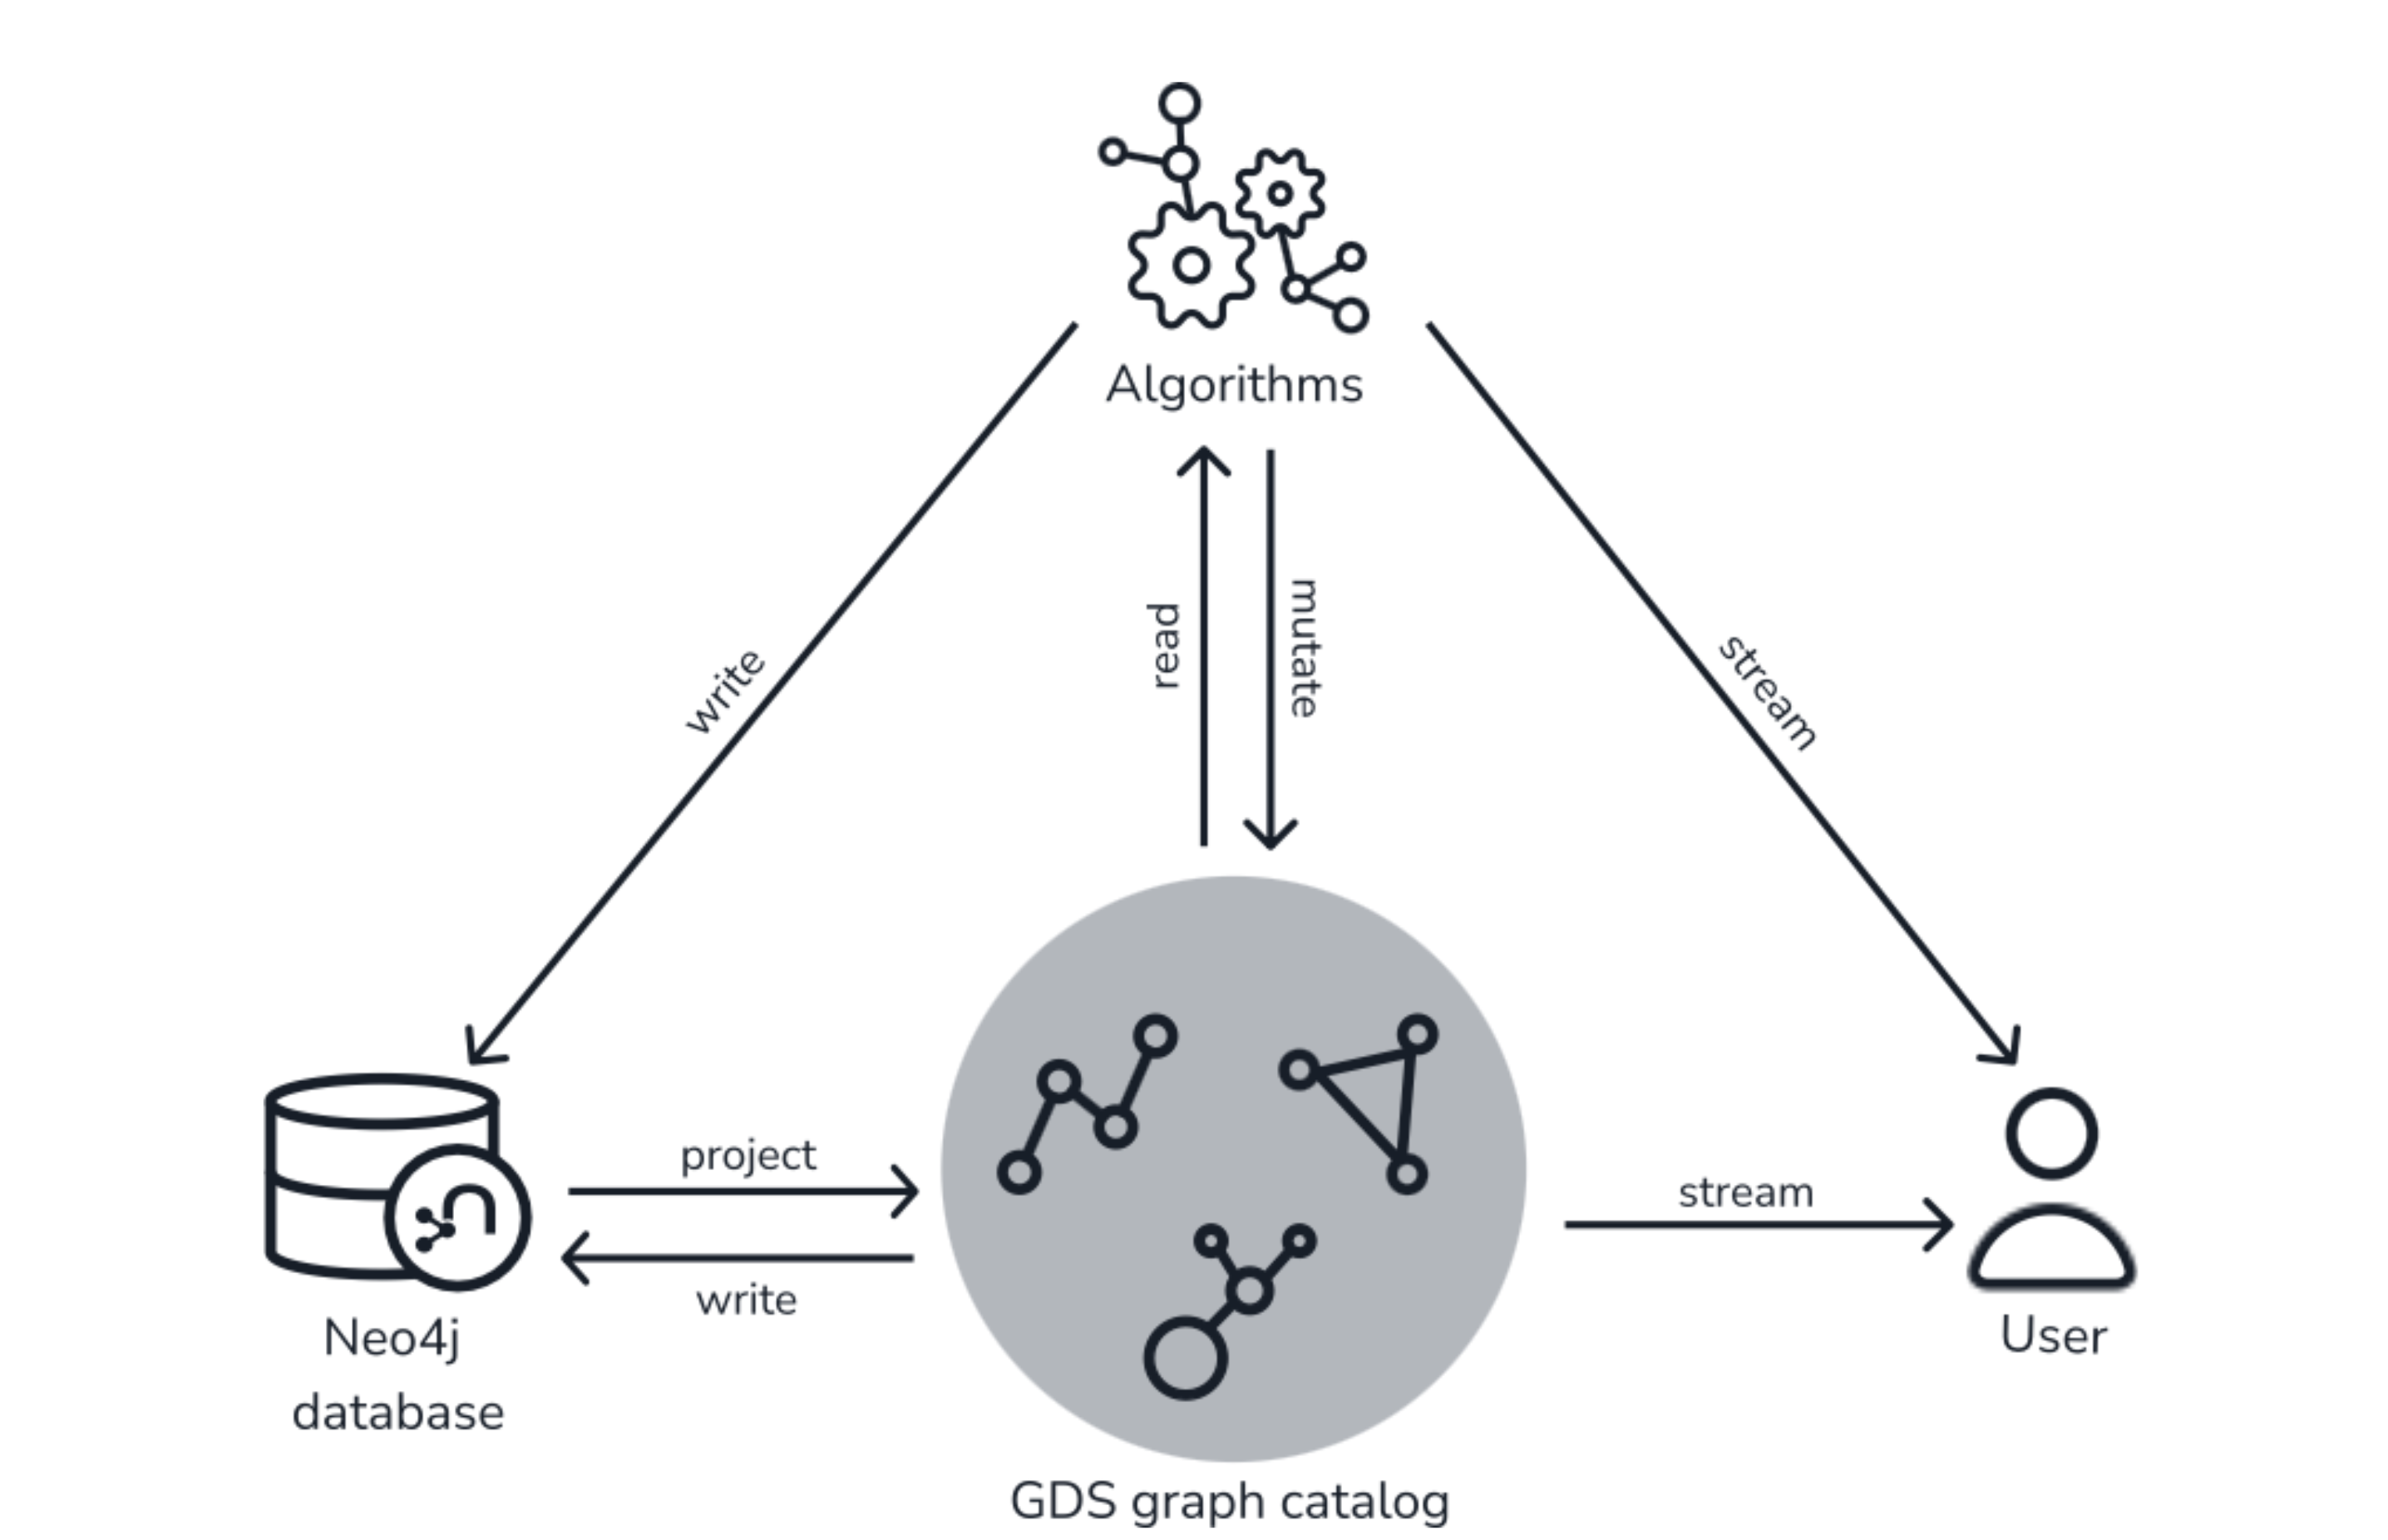

<span style="color:red">Note: __Node properties have to be numerical in order to be projected into a Graph__</span>


In [1]:
import os, sys
import re
import pandas as pd
# Settings #
cwd = os.getcwd()
frameworkDir = os.path.abspath(os.path.join(cwd, os.pardir, os.pardir, 'src'))
print(frameworkDir)
sys.path.append(frameworkDir)
#######################
# Internal Modules #
from dackar.knowledge_graph.pygds import PyGDS
from dackar.knowledge_graph.py2neo import Py2Neo
from dackar.knowledge_graph.graph_utils import set_neo4j_import_folder

/Users/wangc/projects/DACKAR/src


Warming up PyWSD (takes ~10 secs)... took 1.7605183124542236 secs.


## Set import folder path for neo4j and create python to neo4j driver

In [2]:
# Change import folder to user specific location
config_file_path = "/Users/wangc/Library/Application Support/Neo4j Desktop/Application/relate-data/dbmss/dbms-28cea4a5-ad08-4fed-94a1-70d44e297586/conf/neo4j.conf"
import_folder_path = "/Users/wangc/projects/DACKAR/examples/KG_demo/"
set_neo4j_import_folder(config_file_path, import_folder_path)
print(f"Neo4j import folder set to: {import_folder_path}")

# Create python to neo4j driver
# uri = "bolt://localhost:7687" # for a single instance
uri = "neo4j://localhost:7687" # for a cluster
pwd = "123456789" # user need to provide the DBMS database password

pygds = PyGDS(uri=uri, user='neo4j', pwd=pwd)
py2neo = Py2Neo(uri=uri, user='neo4j', pwd=pwd)

Neo4j import folder set to: /Users/wangc/projects/DACKAR/examples/KG_demo/


In [3]:
nodes_info_df = pd.read_csv("https://snap.stanford.edu/data/reachability-meta.csv.gz", compression="gzip")
nodes_info_df.head()

,node_id,name,metro_pop,latitude,longitude
0,0,"Abbotsford, BC",133497.0,49.051575,-122.328849
1,1,"Aberdeen, SD",40878.0,45.459090,-98.487324
2,2,"Abilene, TX",166416.0,32.449175,-99.741424
3,3,"Akron/Canton, OH",701456.0,40.797810,-81.371567
4,4,"Alamosa, CO",9433.0,37.468180,-105.873599


In [4]:
routes_df = pd.read_csv(
    "https://snap.stanford.edu/data/reachability.txt.gz",
    sep=" ",
    skiprows=6,
    header=None,
    compression="gzip",
    names=["Origin", "Destination", "Weight"],
)
routes_df.head()

,Origin,Destination,Weight
0,27,0,-757
1,57,0,-84
2,70,0,-1290
3,74,0,-465
4,86,0,-700


In [5]:
# cleanup neo4j database, and test query function
pygds.query("MATCH (n) DETACH DELETE n")

""


In [6]:
pygds.query(
    "UNWIND $nodes AS node CREATE (n:City {node_id: node.node_id, name: node.name, population: node.metro_pop})",
    params={"nodes": nodes_info_df.to_dict("records")},
)

pygds.query(
    """
    UNWIND $rels AS rel
    MATCH (source:City {node_id: rel.Origin}), (target:City {node_id: rel.Destination})
    CREATE (source)-[:HAS_FLIGHT_TO]->(target)
    """,
    params={"rels": routes_df.to_dict("records")},
)

pygds.centrality(check=True)

In [7]:
# cleanup neo4j database, and test query function
pygds.query("MATCH (n) DETACH DELETE n")

""


In [8]:
# Load data directly into momery
nodes = pd.DataFrame().assign(nodeId=nodes_info_df['node_id'],
                            labels='City',
                            # name=nodes_info_df['name'],
                            population=nodes_info_df['metro_pop'])
relations = pd.DataFrame().assign(sourceNodeId=routes_df['Origin'],
                                targetNodeId=routes_df['Destination'],
                                relationshipType='HAS_FLIGHT_TO',
                                weight=routes_df['Weight'])

pygds.load_dataframe('airline', nodes, relations)

# clean up
pygds.reset()

In [9]:
# from graphdatascience import GraphDataScience
# a= GraphDataScience(uri, auth=('neo4j',pwd), database='neo4j')
# G=a.graph.get('airline')
# G.drop()